* 일련의 예측기를 **앙상블**이라고 부르기 때문에 이를 **앙상블 학습**이라고 하며, 앙상블 학습 알고리즘을 **앙상블 방법**이라고 한다.
* 앙상블 방법의 예를 들면 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있다. 예측을 하려면 모든 개별 트리의 예측을 구하면 된다.  
그런 다음 가장 많은 선택을 받은 클래스를 예측으로 삼습니다.  
결정 트리의 앙상블을 **랜덤 포레스트**라고 합니다.
* 프로젝트의 마지막에 다다르면 흔히 앙상블 방법을 사용하여 이미 만든 여러 괜찮은 예측기를 연결하여 더 좋은 예측기를 만든다.

# 설정

In [2]:
# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 투표 기반 분류기
* 더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것
* 이렇게 다수결 투표로 정해지는 분류기를 **직접 투표** 분류기 라고 한다.
* 조금 놀랍게도 이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많다.
* 사실 각 분류기가 **약한 학습기**(즉, 랜덤 추측보다 조금 더 높은 성능을 내는 분류기)일지라도 충분하게 많고 다양하다면 앙상블은 (높은 정확도를 내는) **강한 학습기**가 될 수 있다.

In [3]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

**<그림 7-3. 큰 수의 법칙> 생성 코드**

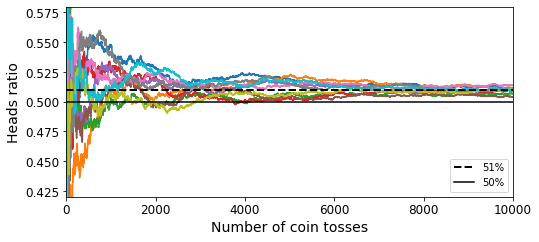

In [4]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

TIP => 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘합니다. 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것입니다.  
이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킵니다.

In [5]:
# moons 데이터셋 사용
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련시키는 코드

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [7]:
# 각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.888


    노트: 사이킷런 알고리즘이 이따금 업데이트되기 때문에 이 노트북의 결과가 책과 조금 다를 수 있습니다.

* 모든 분류기가 클래스의 확률을 예츨할 수 있으면(predict_proba() 메서드가 있으면), 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있는데, 이를 **간접 투표** 라고 한다.
* 이 방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높다.
* 간접 투표를 사용하기 위해 **voting='hard' => voing='soft'** 로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 된다.
* SVC의 기본값에는 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야 한다.

In [8]:
# 간접 투표 코드
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 배깅과 페이스팅
* 앙상블 학습의 또 다른 방법은 같은 알고리즘을 사용하고 훈련셋의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것
* **배깅** : 훈련셋에서 중복을 허용하여 샘플링하는 방식
* **페이스팅** : 중복을 허용하지 않고 샘플링하는 방식
    - 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.
    - 수집 함수는 전형적으로 분류일 때는 **통계적 최빈값**이고 회귀에 대해서는 **평균**을 계산
* 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습시킬 수 있다. 이와 유사하게 예측도 병렬로 수행할 수 있다.

## 사이킷런의 배깅과 페이스팅

In [10]:
# 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드, 배깅으로 선택된 100개의 샘플로 훈련
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1 # 페이스팅을 사용하려면 bootstrap=False로 지정
)                                   # n_jobs매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정
                                    # -1로 지정하면 가용한 모든 코어를 사용
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

NOTE_ BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(predict_proba() 함수가 있으면) 직접 투표 대신 자동으로 간접 투표 방식을 사용

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.92


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


**<그림 7-5. 단일 경정 트리(왼쪽)와 500개 트리로 만든 배깅 앙상블(오른쪽) 비교> 생성 코드**

In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

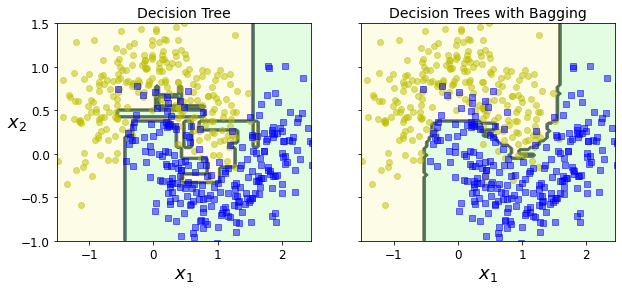

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 더 잘 됨  
앙상블은 비슷한 편향에서 더 작은 분산을 만든다.
* bootstraping은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다.
* 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다. 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호  
시간과 CPU에 자신이 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽 선택

## oob 평가
* 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다.
* BagginClassifier는 기본값으로 중복을 허용하여 훈련셋의 크기만큼인 m개의 샘플을 선택. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링 된다는 것을 의미
* 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out-of-bag)샘플이라고 부른다.
* 예측기가 훈련되는 동안에는 oob샘플을 사용하지 않으므로 별도의 검증셋을 사용하지 않고 oob샘플을 사용해 평가할 수 있다. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.
* 사이킷런에서 BaggingClassifier를 만들때 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행

In [15]:
# oob 평가 수행 코드 (검증 수행)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [16]:
# 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [17]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

# 랜덤 패치와 랜덤 서브스페이스
* BaggingClassifier는 특성 샘플링도 지원한다. 샘플링은 max_features, bootstrap_features 두 매개변수로 조절. 작동 방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링이다.
* 이 기법은 특히 매우 고차원의 데이터셋을 다룰 때 유용하다.
* **랜덤 패치 방식** : 훈련 특성과 샘플을 모두 샘플링하는 것
* **랜덤 서브스페이스** : 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

# 랜덤 포레스트
* 랜덤 포레스트는 일반적으로 배깅 방법을 적용한 결정 트리의 앙상블이다.
* 전형적으로 max_samples를 훈련셋의 크기로 지정한다.

In [18]:
# 최대 16개 리프노드를 갖는 500개 트리로 이뤄진 랜덤 포레스트 분류기 훈련 코드
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [19]:
# BaggingClassifier와 DecisionTreeClassifier를 사용해 랜덤 포레스트와 유사하게 만든 코드
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

In [20]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일합니다.

1.0

## 엑스트라 트리
* 랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용.  
이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤 트리** 앙상블 혹은 **엑스트라 트리** 라고 부른다.
* 여기서도 역시 편향이 늘어나지만 대신 분산을 낮추게 된다.
* 모든 노드에서 특성마다 가장 최적의 임계값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업으로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다.

## 특성 중요도
* 랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다.
* 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다.
* 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화한다.

In [22]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    # 각 특성의 중요도 출력
    print(name, score)

sepal length (cm) 0.09934873593966811
sepal width (cm) 0.02288187581472086
petal length (cm) 0.4167536451372604
petal width (cm) 0.46101574310835064


**<그림 7-6. (랜덤 포레스트 분류기에서 얻은) MNIST 픽셀 중요도> 생성 코드**

In [23]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [24]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [25]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

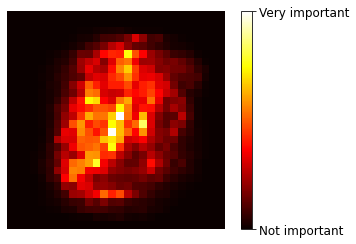

In [26]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

# 부스팅
* 부스팅 : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
    - 아이디어 : 앞의 모델을 보완해나가면서 일련의 예측기를 학습시킴
    - 부스팅의 대표적인 방법으로는 **에이다부스트(AdaBoost)**와 **그레디언트 부스트(gradient boosting)** 이 있다.

## 에이다부스트
* 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것. 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 되며 이것이 에이다부스트에서 사용하는 방식이다.  
**CAUTION_* 연속된 학습 기법에는 중요한 단점이 있다. 각 예측기는 이전 예측기가 훈련되고 평가된 후에 학습될 수 있기 때문에 병렬화(또는 분할)를 할 수 없다. 결국 배깅이나 페이스팅만큼 확장성이 높지 않다.
* 사이킷런은 SAMME 라는 에이다부스트의 다중 클래스 버전을 사용한다.

In [28]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

TIP => 에이다부스트 앙상블이 훈련 세트에 과대적합되면 추정기 수를 줄이거나 추정기의 규제를 더 강하게 해보자

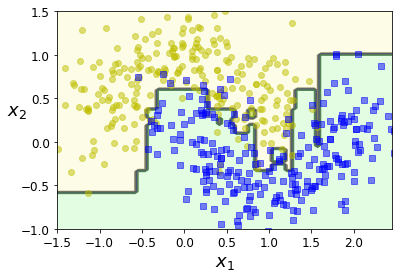

In [29]:
plot_decision_boundary(ada_clf, X, y)

**<그림 7-8. 연속된 예측기의 결정 경계> 생성 코드**

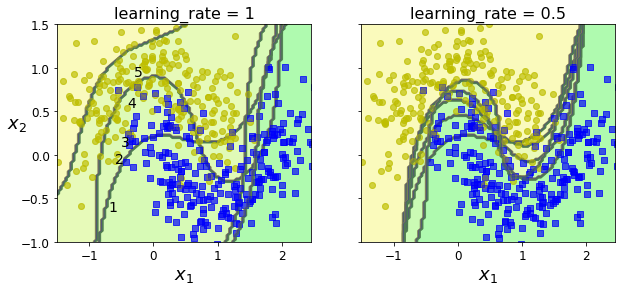

In [30]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

## 그레디언트 부스팅
* 에이다부스트처럼 그레디언트 부스팅 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다.
* 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 **잔여 오차**에 새로운 예측기를 학습시킨다.
* 그레디언트 트리 부스팅 or 그레디언트 부스티드 회귀 트리 : 결정 트리를 기반 예측기로 사용하는 회귀알고리즘

In [31]:
# 잡음이 섞인 2차식 형태의 데이터셋
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [33]:
# 결정 회귀 트리를 훈련셋에 학습시키는 코드
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [44]:
# 첫번째 예측기에 생긴 잔여 오차에 두번째 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [45]:
# 두번째 예측기에 생긴 잔여 오차에 세번째 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [46]:
X_new = np.array([[0.8]])

In [47]:
# 모든 트리의 예측값을 더함
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [48]:
y_pred

array([0.75026781])

**<그림 7-9> 생성 코드**

In [49]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

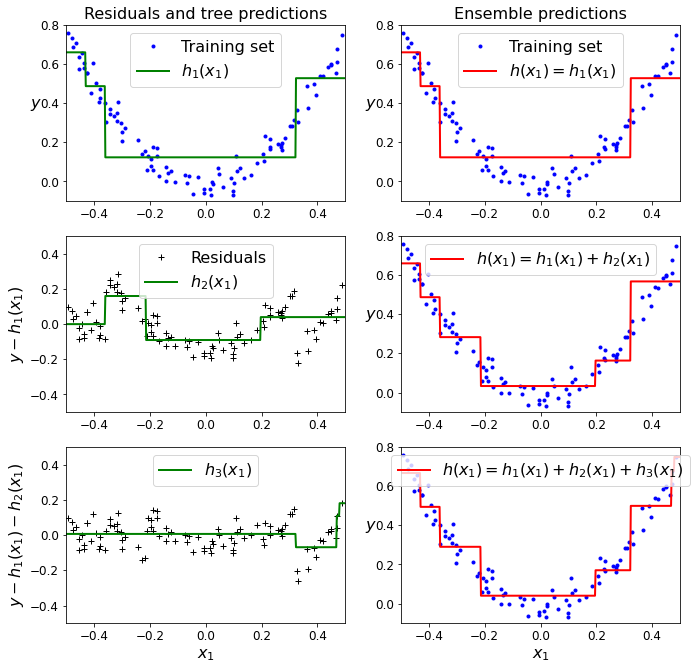

In [50]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [51]:
# 이전에 만든 것과 같은 앙상블을 그레디언트 부스팅 회귀 모델로 구현
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

**<그림 7-10. 예측기가 부족한 경우(왼쪽)과 너무 많은 경우(오른쪽)의 GBRT 앙상블> 생성 코드**

In [52]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

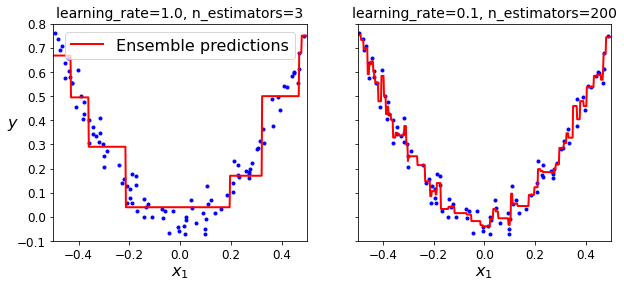

In [53]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

learning_rate 매개변수가 각 트리의 기여 정도를 조절한다. 이를 0.1처럼 낮게 설정하면 앙상블을 훈련셋에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아지는데 이는 **축소**라고 부르는 규제 방법이다.  
왼쪽은 트리가 충분하지 않아 과소적합, 오른쪽은 트리가 너무 많아 과대적합 되었음

#### 조기 종료를 사용한 그레디언트 부스팅

In [57]:
import numpy as no
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

**<그림 7-11. 조기 종료를 사용하여 트리 수 튜닝> 생성 코드**

In [58]:
min_error = np.min(errors)

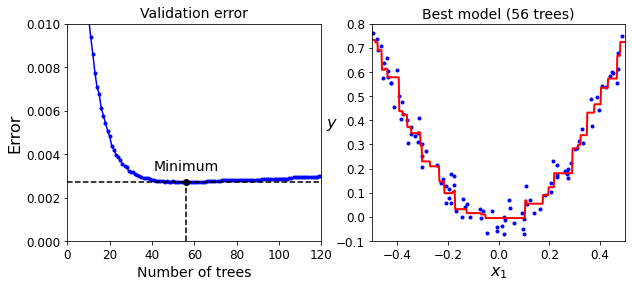

In [59]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

In [60]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [61]:
print(gbrt.n_estimators)

61


In [64]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


* 확률적 그레디언트 부스팅 : subsample을 활용하여 무작위로 선택된 훈련샘플을 학습하는 방법

### XGBoost 사용하기

In [65]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [66]:
if xgboost is not None:  # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # 책에 없음
    print("Validation MSE:", val_error)           # 책에 없음

Validation MSE: 0.004000408205406276


In [67]:
if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
    print("Validation MSE:", val_error)            # 책에 없음

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


C:\Users\hoseop\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


# 스태킹
* 앙상블에 속한 모든 예측기의 예측을 취합하는 간단함 함수(직접 투표 같은)를 사용하는 대신 취합하는 모델을 훈련시킬수는 없을까?라는 아이디어로 부터 나옴

# 연습문제

1. 정확히 같은 훈련 데이터로 다섯 개의 다른 모델을 훈련시켜서 모두 95% 정확도를 얻었다면 이 모델들을 연결하여 더 좋은 결과를 얻을 수 있을까요? 가능하다면 어떻게 해야 할까 요? 그렇지 않다면 왜일까요?

다섯개의 모델을 훈련시켰고 모두 95%의 정확도를 달성했다면 이들을 연결하여 투표 앙상블(voting ensemble)을 만들어 더 나은 결과를 기대 할 수 있다.  
만약 모델이 서로 다르다면(예를 들면 SVM분류기, 결정트리 분류기, 로지스틱 회귀 분류기 등) 훨씬 좋다.
만약 다른 훈련 샘플에서 훈련되었다면 더더욱 좋다.(이것이 배깅과 페이스팅 앙상블의 핵심)
하지만 그렇지 않더라고 모델이 서로 많이 다르면 여전히 좋은 결과를 낸다.

2. 직접 투표와 간접 투표 분류기 사이의 차이점은 무엇일까요?

직접 투표 분류기는 앙상블에 있는 각 분류기의 선택을 카운트해서 가장 많은 투표를 얻는 클래스를 선택한다.  
간접 투표 분류기는 각 클래스의 평균적인 확률 추정값을 계산해서 가장 높은 확률을 가진 클래스를 고른다.  
이 방식은 신뢰가 높은 투표에 더 가중치를 주고 종종 더 나은 성능을 낸다.  
하지만 앙상블에 있는 모든 분류기가 클래스 확률을 추정할 수 있어야 사용할 수 있다.(예를 들어 사이킷런의 SVM 분류기는 probability = True 로 지정해야 한다.)

3. 배깅 앙상블의 훈련을 여러 대의 서버에 분산시켜 속도를 높일 수 있을까요? 페이스팅 앙상블, 부스팅 앙상블, 랜덤 포레스트, 스태킹 앙상블의 경우는 어떨까요?

배깅 앙상블의 각 예측기는 독립적이므로 여러 대의 서버에 분산하여 앙상블의 훈련 속도를 높일 수 있다.  
페이스팅 앙상블과 랜덤 포레스트도 같은 이유로 동일하다.  
그러나 부스팅 앙상블의 예측기는 이전 예측기를 기반으로 만들어지므로 훈련이 순차적이어야하고 여러 대의 서버에 분산해서 얻을 수있는 이득이 없다.  
스태킹 앙상블의 경우 한 층의 모든 예측기가 각각 독립적이므로 여러대의 서버에서 병렬로 훈련 될 수 있다.  
그러나 한 층에 있는 예측기들은 이전 층의 예측기들이 훈련된 후에 훈련 될 수 있다.

4. oob 평가의 장점은 무엇인가요?

oob 평가를 사용하면 배깅 앙상블의 각 예측기가 훈련에 포함되지 않은(즉, 따로 떼어놓은) 샘플을 사용해 평가된다.  
이는 추가적인 검증 세트가 없어도 편향되지 않게 앙상블을 평가하도록 도와준다.  
그러므로 훈련에 더 많은 샘플을 사용할 수 있어서 앙상블의 성능은 조금 더 향상될 것이다.

5. 무엇이 엑스트라 트리를 일반 랜덤 포레스트보다 더 무작위하게 만드나요? 추가적인 무작 위성이 어떻게 도움이 될까요? 엑스트라 트리는 일반 랜덤 포레스트보다 느릴까요, 빠를 까요?

랜덤 포레스트에서 트리가 성장할 때 각 노드에서 특성의 일부를 무작위로 선택해 분할에 사용한다.  
엑스트라 트리에서도 이는 마찬가지지만 한 단계 더 나아가서 일반 결정 트리처럼 가능한 최선의 임계점을 찾는 것이 아니라 각 특성에 대해 랜덤한 임계점을 사용한다.  
이 추가적인 무작위성은 규제처럼 작동한다.  
즉, 랜덤 포레스트가 훈련 데이터에 과대 적합되었다면 엑스트라 트리는 그렇지 않을 것이다.  
또한 엑스트라 트리는 가능한 최선의 임계점을 찾지 않기 때문에 랜덤 포레스트보다훨씬 빠르게 훈련된다.  
그러나 예측을 할 때는 랜덤 포레스트보다 더 빠르지도 느리지도 않다.  

6. 에이다부스트 앙상블이 훈련 데이터에 과소적합되었다면 어떤 매개변수를 어떻게 바꾸어야 할까요?

에이다부스트 앙상블이 훈련 데이터에 과소적합되었다면 예측기 수를 증가시키거나 기반 예측기의 규제 하이퍼파라미터를 감소시켜 볼 수 있다.  
또한 학습률을 약간 증가 시켜 볼 수 있다.

7. 그레이디언트 부스팅 앙상블이 훈련 데이터에 과대적합되었다면 학습률을 높여야 할까요, 낮춰야 할까요?

그레이디언트 부스팅 앙상블이 훈련 세트에 과대적합되었다면 학습률을 감소 시켜야한다.  
(예측기 수가 너무 많으면) 알맞은 개수를 찾기 위해 조기 종료 기법을 사용할 수 있다.

8. (3장에서 소개한) MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕 니다(예를 들면 훈련에 50,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플). 그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 분류기 같은 여러 종류의 분류기를 훈련시킵니다. 그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 방법을 사용해 앙상블로 연결해보세요. 앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
# 훈련세트, 검증세트, 테스트 세트로 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [70]:
#랜덤 포레스트 분류기, 엑스트라 분류기, SVM 같은 여러 종류의 분류기 훈련
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [71]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [72]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [74]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9635]

선형 SVM이 다른 분류기보다 성능이 많이 떨어집니다. 그러나 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 두겠습니다.



그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요.

In [75]:
from sklearn.ensemble import VotingClassifier

In [76]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [77]:
voting_clf = VotingClassifier(named_estimators)

In [78]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [79]:
voting_clf.score(X_val, y_val)

0.9715

In [80]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9635]

SVM 모델을 제거해서 성능이 향상되는지 확인해 보죠. 다음과 같이 set_params()를 사용하여 None으로 지정하면 특정 예측기를 제외시킬 수 있습니다:

In [81]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

예측기 목록이 업데이트되었습니다

In [82]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

하지만 훈련된 예측기 목록은 업데이트되지 않습니다

In [83]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

VotingClassifier를 다시 훈련시키거나 그냥 훈련된 예측기 목록에서 SVM 모델을 제거할 수 있습니다

In [84]:
del voting_clf.estimators_[2]

VotingClassifier를 다시 평가해 보죠:

In [85]:
voting_clf.score(X_val, y_val)

0.9736

훨씬 나아졌네요! SVM 모델이 성능을 저하시켰습니다. 이제 간접 투표 분류기를 사용해 보죠. 분류기를 다시 훈련시킬 필요는 없고 voting을 "soft"로 지정하면 됩니다:

In [86]:
voting_clf.voting = "soft"

In [87]:
voting_clf.score(X_val, y_val)

0.9708

이 경우는 직접 투표 방식이 낫네요.

앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?

In [88]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9697

In [89]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9599]

여기서는 투표 기반 분류기가 최선의 모델의 오차율을 아주 조금만 감소시킵니다.

9. 이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터이고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요.

In [90]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [91]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [92]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [93]:
rnd_forest_blender.oob_score_

0.9696

 축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다! 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?

In [94]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [95]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [96]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9673

이 스태킹 앙상블은 앞서 만든 투표 기반 분류기만큼 성능을 내지는 못합니다. 최선의 개별 분류기만큼 뛰어나지는 않습니다.